In [1]:
import requests
import json
import os
import json
import os



RSA_SIZE = 2048


DEFAULT_CURVE = "secp384r1"
FAST_CURVE = "secp256r1"
SUPPORTED_CURVES = [DEFAULT_CURVE, FAST_CURVE]

DIGEST_SHA384 = "sha384"
DIGEST_SHA256 = "sha256"

RSA_SIZE = 2048
# CCF network node
server="https://127.0.0.1:8000"

num_users = 4
# Getting Network metrices
url = server + "/app/api/metrics"

try:
    response = requests.get(url, verify='./workspace/sandbox_common/service_cert.pem')

    print("Status Code:", response.status_code)
    print("\nResponse Headers:")
    for header, value in response.headers.items():
        print(f"{header}: {value}")

    print("\nResponse Body:")
    try:
        # Attempt to parse JSON and print it in an indented format
        response_json = response.json()
        print(json.dumps(response_json, indent=4))
    except ValueError:
        # If response is not JSON, print as plain text
        print(response.text)

except requests.exceptions.RequestException as e:
    print("Error making request:", e)

Status Code: 200

Response Headers:
content-length: 176
content-type: application/json

Response Body:
{
    "metrics": [
        {
            "calls": 1,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "api/metrics",
            "retries": 0
        },
        {
            "calls": 2,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "commit",
            "retries": 0
        }
    ]
}


In [2]:
%pip install matplotlib
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azure-core 1.29.7 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL



def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights =deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None


def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []
def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id,round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)
  
    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")
def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    return history.history['loss']

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')
    

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
      "global_model": {
        "model_name": "CNNModel",
        "model_data": model_base64
      }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None
def flatten_weights(model):
    """Flatten the model weights"""
    flat_weights = []
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:
            flat_weights.append(weights[0].flatten())
    return np.concatenate(flat_weights)
def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights


def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights



def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    # flat_weights = flatten_weights(model)
    local_model_weights = model.get_weights()
    # Serialize the weights using numpy's tolist() method

    
    serialized_weights = json.dumps(flat_weights.tolist())
    return serialized_weights



def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
  

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data
            
            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")
        
        time.sleep(2)  # Delay before retrying
        attempts += 1
    
    raise Exception("Failed to download model after maximum retries.")
def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()
def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]
        
        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Conv2D):
                    # Check if it's a Conv2D layer
                    weights_shape = local_layers[i].get_weights()[0].shape
                    provided_weights_shape = global_model_weights[i][0].shape
                    print(f"Layer {local_layers[i].name} - Expected shape: {weights_shape}, Provided shape: {provided_weights_shape}")
                    
                    if weights_shape == provided_weights_shape:
                        local_layers[i].set_weights([global_model_weights[i][0], global_model_weights[i][1]])
                    else:
                        try:
                            reshaped_kernel_weights = np.reshape(global_model_weights[i][0], weights_shape)
                            local_layers[i].set_weights([reshaped_kernel_weights, global_model_weights[i][1]])
                        except ValueError as e:
                            print(f"Error reshaping weights for layer {local_layers[i].name}: {e}")
                elif isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                # Add similar checks for other layer types if needed
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

2024-02-04 22:02:09.370141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 22:02:09.422912: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 22:02:09.424469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 22:02:10.241488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# Load and preprocess MNIST dataset
print("Loading and preprocessing MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()
# Split the dataset for two users
print("Splitting dataset for two users...")
split_index = int(len(X_train) / 2)
X_train_user0, X_train_user1 = np.split(X_train, [split_index])
y_train_user0, y_train_user1 = np.split(y_train, [split_index])

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, X_train_user0, y_train_user0, X_test, y_test, user_id=0, round_no=0)


Loading and preprocessing MNIST dataset...
Deleted temporary model file: temp_model.h5
Splitting dataset for two users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
938/938 [==============================] - 14s 14ms/step - loss: 0.5649 - accuracy: 0.9036 - val_loss: 0.1224 - val_accuracy: 0.9611
Epoch 2/2
938/938 [==============================] - 13s 14ms/step - loss: 0.1095 - accuracy: 0.9678 - val_loss: 0.0887 - val_accuracy: 0.9742


[0.5649380683898926, 0.10946600884199142]

In [8]:
# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

Serializing the model...
Uploading initial global model...
Initial global model 'CNNModel' (ID: 2) uploaded successfully.


/workspaces/ccf-app-template/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")
num_rounds = 4  # Number of training rounds
user_losses = {0: [], 1: []}  # To track losses for each user

# Download the latest global model once for each client
global_model = download_model(
    "./workspace/sandbox_common/user0_cert.pem",
    "./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for both users
local_model_user0 = global_model
local_model_user1 = global_model

for round_no in range(1, num_rounds + 1):
    for user_id in range(2):  # Two users: 0 and 1
        # Train the local model on the user's data
        X_train_user = X_train_user0 if user_id == 0 else X_train_user1
        y_train_user = y_train_user0 if user_id == 0 else y_train_user1
        loss = train_model(local_model_user0 if user_id == 0 else local_model_user1,
                           X_train_user, y_train_user, X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_model_user0 if user_id == 0 else local_model_user1)
        # Upload model weights only if they are not empty

        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id,round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_model_user0
    )

print("Federated Learning Process Completed.")

# Plot loss graphs for each user
plot_loss(user_losses)
delete_temp_model_file()

In [60]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.datasets import mnist
# import json

# # Function to create the global model
# def create_model():
#     print("Initializing the global model...")
#     model = Sequential([
#         Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
#         MaxPooling2D(pool_size=(2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(10, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Function to train a local model
# def train_local_model(local_model, x_train, y_train):
#     y_train = to_categorical(y_train, num_classes=10)
#     local_model.fit(x_train, y_train, epochs=3, batch_size=32)
#     local_weights = local_model.get_weights()
#     return local_weights

# # Function to flatten weights
# def flatten_weights(weights):
#     return np.concatenate([arr.flatten() for arr in weights])

# # Function to unflatten weights
# def unflatten_weights(flat_weights, original_shapes):
#     unflattened_weights = []
#     index = 0
#     for shape in original_shapes:
#         size = np.prod(shape)
#         unflattened_weights.append(flat_weights[index:index + size].reshape(shape))
#         index += size
#     return unflattened_weights

# # Function to serialize weights
# def serialize_weights(weights):
#     flat_weights = flatten_weights(weights)
#     return json.dumps(flat_weights.tolist())

# # Function to deserialize weights
# def deserialize_weights(serialized_weights, original_shapes):
#     flat_weights = np.array(json.loads(serialized_weights))
#     return unflatten_weights(flat_weights, original_shapes)

# # Function to federated averaging
# def federated_average(weights_list):
#     # Flatten weights before averaging
#     flat_weights_list = [flatten_weights(weights) for weights in weights_list]
    
#     # Perform federated averaging on flattened weights
#     global_flat_weights = np.mean(flat_weights_list, axis=0)
    
#     # Unflatten the averaged weights
#     global_original_shapes = [weights.shape for weights in weights_list[0]]
#     global_weights = unflatten_weights(global_flat_weights, global_original_shapes)
    
#     return global_weights

# # Load MNIST data
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
# x_test = x_test.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

# # Federated learning simulation
# num_clients = 2
# global_model = create_model()

# for round in range(3):
#     print(f"\nRound {round + 1} of Federated Learning:")
    
#     # Train local models on each client
#     local_model_1 = create_model()
#     local_weights_1 = train_local_model(local_model_1, x_train[:3000], y_train[:3000])
    
#     local_model_2 = create_model()
#     local_weights_2 = train_local_model(local_model_2, x_train[3000:], y_train[3000:])
    
#     # Get local updates
#     local_weights_list = [local_weights_1, local_weights_2]
    
#     # Serialize local updates for communication
#     serialized_weights_list = [serialize_weights(weights) for weights in local_weights_list]
    
#     # Perform federated averaging
#     global_model_weights = federated_average(local_weights_list)
    
#     # Update global model
#     global_model.set_weights(global_model_weights)
    
#     # Deserialize and update local models for the next round
#     for i in range(num_clients):
#         local_model = create_model()
#         local_weights_deserialized = deserialize_weights(serialized_weights_list[i], [weights.shape for weights in local_weights_list[0]])
#         local_model.set_weights(local_weights_deserialized)
#         print(f"Client {i + 1} updated with global weights for the next round.")


Initializing the global model...

Round 1 of Federated Learning:
Initializing the global model...
Epoch 1/3
94/94 [==============================] - 1s 10ms/step - loss: 0.6610 - accuracy: 0.8093
Epoch 2/3
94/94 [==============================] - 1s 11ms/step - loss: 0.2367 - accuracy: 0.9323
Epoch 3/3
94/94 [==============================] - 1s 11ms/step - loss: 0.1477 - accuracy: 0.9567
Initializing the global model...
Epoch 1/3
1782/1782 [==============================] - 20s 11ms/step - loss: 0.1538 - accuracy: 0.9545
Epoch 2/3
1782/1782 [==============================] - 19s 10ms/step - loss: 0.0532 - accuracy: 0.9834
Epoch 3/3
1782/1782 [==============================] - 19s 11ms/step - loss: 0.0333 - accuracy: 0.9900
Initializing the global model...
Client 1 updated with global weights for the next round.
Initializing the global model...
Client 2 updated with global weights for the next round.

Round 2 of Federated Learning:
Initializing the global model...
Epoch 1/3
94/94 [====


Round 1 of Federated Learning:
Client 1 updated with global weights for the next round.
Client 2 updated with global weights for the next round.

Round 2 of Federated Learning:
Client 1 updated with global weights for the next round.
Client 2 updated with global weights for the next round.

Round 3 of Federated Learning:
Client 1 updated with global weights for the next round.
Client 2 updated with global weights for the next round.


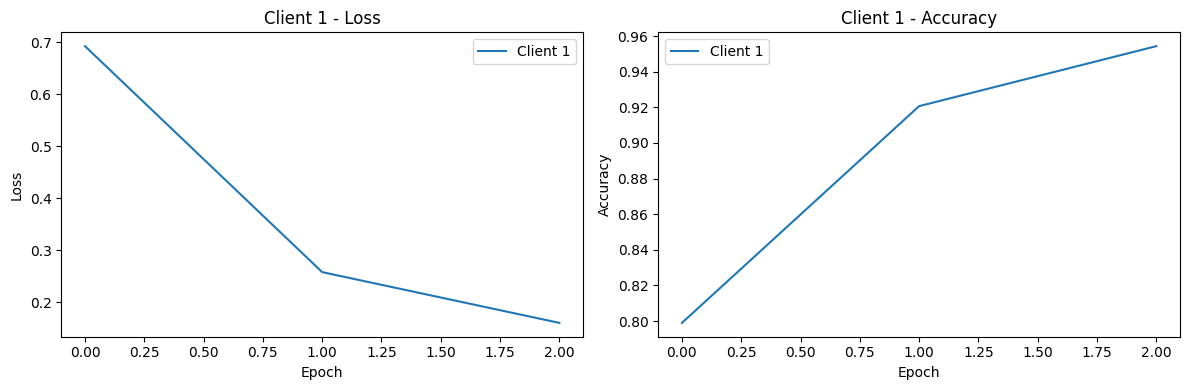

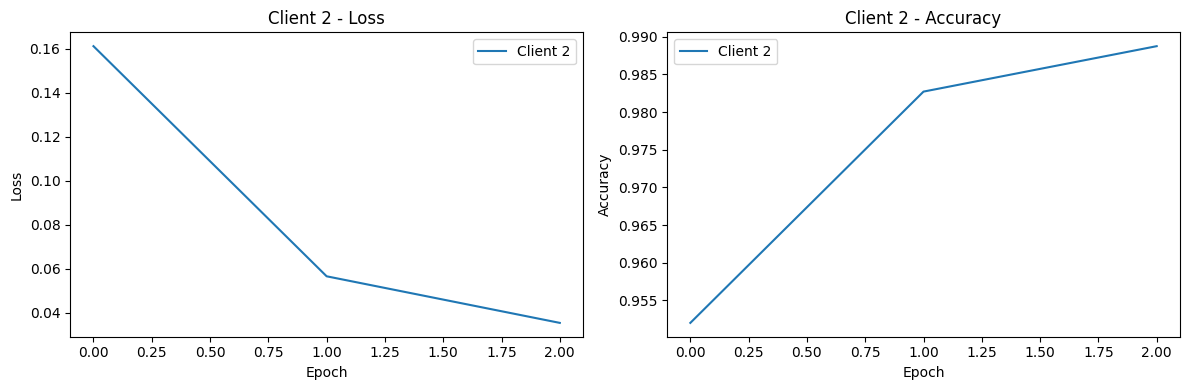

In [61]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.datasets import mnist
# import json

# # Function to create the global model
# def create_model():
#     model = Sequential([
#         Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
#         MaxPooling2D(pool_size=(2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(10, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Function to train a local model and return loss and accuracy
# def train_local_model(local_model, x_train, y_train):
#     y_train = to_categorical(y_train, num_classes=10)
#     history = local_model.fit(x_train, y_train, epochs=3, batch_size=32, verbose=0)
#     local_weights = local_model.get_weights()
#     return local_weights, history

# # Function to flatten weights
# def flatten_weights(weights):
#     return np.concatenate([arr.flatten() for arr in weights])

# # Function to unflatten weights
# def unflatten_weights(flat_weights, original_shapes):
#     unflattened_weights = []
#     index = 0
#     for shape in original_shapes:
#         size = np.prod(shape)
#         unflattened_weights.append(flat_weights[index:index + size].reshape(shape))
#         index += size
#     return unflattened_weights

# # Function to serialize weights
# def serialize_weights(weights):
#     flat_weights = flatten_weights(weights)
#     return json.dumps(flat_weights.tolist())

# # Function to deserialize weights
# def deserialize_weights(serialized_weights, original_shapes):
#     flat_weights = np.array(json.loads(serialized_weights))
#     return unflatten_weights(flat_weights, original_shapes)

# # Function to federated averaging
# def federated_average(weights_list):
#     # Flatten weights before averaging
#     flat_weights_list = [flatten_weights(weights) for weights in weights_list]
    
#     # Perform federated averaging on flattened weights
#     global_flat_weights = np.mean(flat_weights_list, axis=0)
    
#     # Unflatten the averaged weights
#     global_original_shapes = [weights.shape for weights in weights_list[0]]
#     global_weights = unflatten_weights(global_flat_weights, global_original_shapes)
    
#     return global_weights

# # Load MNIST data
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
# x_test = x_test.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

# # Federated learning simulation
# num_clients = 2
# global_model = create_model()

# # Lists to store loss and accuracy for each client
# loss_history_per_client = []
# accuracy_history_per_client = []

# for round in range(3):
#     print(f"\nRound {round + 1} of Federated Learning:")
    
#     # Train local models on each client and collect loss and accuracy
#     local_model_1 = create_model()
#     local_weights_1, history_1 = train_local_model(local_model_1, x_train[:3000], y_train[:3000])
    
#     local_model_2 = create_model()
#     local_weights_2, history_2 = train_local_model(local_model_2, x_train[3000:], y_train[3000:])
    
#     loss_history_per_client.append([history_1.history['loss'], history_2.history['loss']])
#     accuracy_history_per_client.append([history_1.history['accuracy'], history_2.history['accuracy']])
    
#     # Get local updates
#     local_weights_list = [local_weights_1, local_weights_2]
    
#     # Serialize local updates for communication
#     serialized_weights_list = [serialize_weights(weights) for weights in local_weights_list]
    
#     # Perform federated averaging
#     global_model_weights = federated_average(local_weights_list)
    
#     # Update global model
#     global_model.set_weights(global_model_weights)
    
#     # Deserialize and update local models for the next round
#     for i in range(num_clients):
#         local_model = create_model()
#         local_weights_deserialized = deserialize_weights(serialized_weights_list[i], [weights.shape for weights in local_weights_list[0]])
#         local_model.set_weights(local_weights_deserialized)
#         print(f"Client {i + 1} updated with global weights for the next round.")

# # Plot loss and accuracy for each client during each round
# for i in range(num_clients):
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(loss_history_per_client[round][i], label=f'Client {i + 1}')
#     plt.title(f'Client {i + 1} - Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(accuracy_history_per_client[round][i], label=f'Client {i + 1}')
#     plt.title(f'Client {i + 1} - Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()


## Experiment for Non CNN model with fashion MNIST dataset

Loading and preprocessing Fashion MNIST dataset...
Deleted temporary model file: temp_model.h5
Splitting dataset for two users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
938/938 [==============================] - 4s 4ms/step - loss: 5.2001 - accuracy: 0.6623 - val_loss: 1.0639 - val_accuracy: 0.6612
Epoch 2/2
938/938 [==============================] - 3s 4ms/step - loss: 0.8221 - accuracy: 0.7244 - val_loss: 0.8043 - val_accuracy: 0.7143
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 1) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 0, Round 1...
Epoch 1/2
938/938 [==============================] - 3s 3ms/step - loss: 0.6992 - accuracy: 0.7474 - val_loss: 0.7425 - val_accuracy: 0.7553
Epoch 2/2
938/938 [==============================] - 3s 4ms/step - loss: 0.6378 - accuracy: 0.7655 - val_loss: 0.6761 - val_accuracy: 0.7719
Uplo

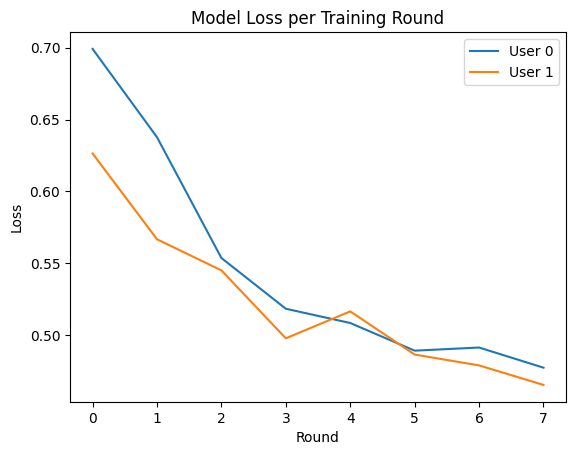

Deleted temporary model file: temp_model.h5


In [5]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL


def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None


def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []


def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")


def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    return history.history['loss']


def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')


def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None


def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)


def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights


def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights


def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights


def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")


def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")


def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")


def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()


def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")


# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for two users
print("Splitting dataset for two users...")
split_index = int(len(X_train) / 2)
X_train_user0, X_train_user1 = np.split(X_train, [split_index])
y_train_user0, y_train_user1 = np.split(y_train, [split_index])

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, X_train_user0, y_train_user0, X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

num_rounds = 4  # Number of training rounds
user_losses = {0: [], 1: []}  # To track losses for each user

# Download the latest global model once for each client
global_model = download_model(
    "./workspace/sandbox_common/user0_cert.pem",
    "./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for both users
local_model_user0 = global_model
local_model_user1 = global_model

for round_no in range(1, num_rounds + 1):
    for user_id in range(2):  # Two users: 0 and 1
        # Train the local model on the user's data
        X_train_user = X_train_user0 if user_id == 0 else X_train_user1
        y_train_user = y_train_user0 if user_id == 0 else y_train_user1
        loss = train_model(local_model_user0 if user_id == 0 else local_model_user1,
                           X_train_user, y_train_user, X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_model_user0 if user_id == 0 else local_model_user1)
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_model_user0
    )

print("Federated Learning Process Completed.")

# Plot loss graphs for each user
plot_loss(user_losses)
delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for two users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
938/938 [==============================] - 4s 4ms/step - loss: 6.5879 - accuracy: 0.6841 - val_loss: 1.0123 - val_accuracy: 0.6937
Epoch 2/2
938/938 [==============================] - 3s 3ms/step - loss: 0.8494 - accuracy: 0.7038 - val_loss: 0.8763 - val_accuracy: 0.7017
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 2) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 0, Round 1...
Epoch 1/2
938/938 [==============================] - 4s 3ms/step - loss: 0.6738 - accuracy: 0.7561 - val_loss: 0.7047 - val_accuracy: 0.7657
Epoch 2/2
938/938 [==============================] - 3s 3ms/step - loss: 0.6153 - accuracy: 0.7764 - val_loss: 0.7163 - val_accuracy: 0.7507


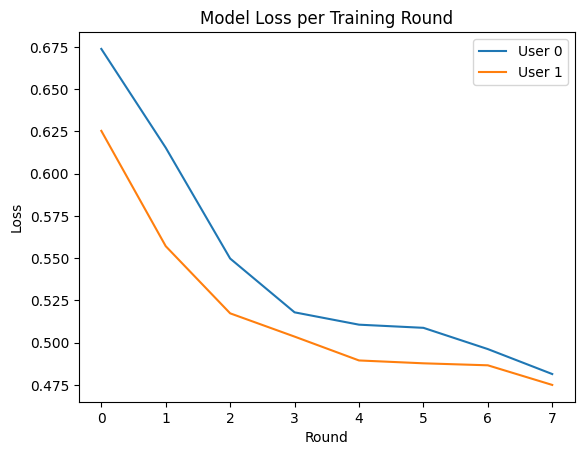

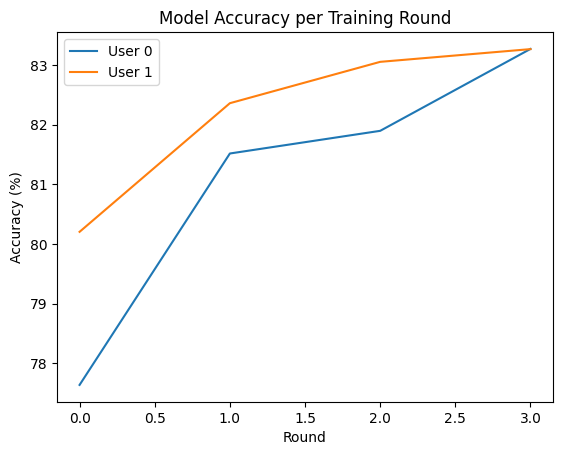

Deleted temporary model file: temp_model.h5


In [6]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def plot_accuracy(user_accuracies):
    for user_id, accuracies in user_accuracies.items():
        plt.plot(accuracies, label=f'User {user_id}')
    plt.title('Model Accuracy per Training Round')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for two users
print("Splitting dataset for two users...")
split_index = int(len(X_train) / 2)
X_train_user0, X_train_user1 = np.split(X_train, [split_index])
y_train_user0, y_train_user1 = np.split(y_train, [split_index])

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, X_train_user0, y_train_user0, X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

num_rounds = 4  # Number of training rounds
user_losses = {0: [], 1: []}  # To track losses for each user
user_accuracies = {0: [], 1: []}  # To track accuracies for each user

# Download the latest global model once for each client
global_model = download_model(
    "./workspace/sandbox_common/user0_cert.pem",
    "./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for both users
local_model_user0 = global_model
local_model_user1 = global_model

for round_no in range(1, num_rounds + 1):
    for user_id in range(2):  # Two users: 0 and 1
        # Train the local model on the user's data
        X_train_user = X_train_user0 if user_id == 0 else X_train_user1
        y_train_user = y_train_user0 if user_id == 0 else y_train_user1
        loss, accuracy = train_model(local_model_user0 if user_id == 0 else local_model_user1,
                           X_train_user, y_train_user, X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_model_user0 if user_id == 0 else local_model_user1)
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_model_user0
    )

print("Federated Learning Process Completed.")

# Plot loss and accuracy graphs for each user
plot_loss(user_losses)
plot_accuracy(user_accuracies)

delete_temp_model_file()


## Experiment with Dynamic list


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 9.2297 - accuracy: 0.6681 - val_loss: 1.4851 - val_accuracy: 0.6301
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 1.0423 - accuracy: 0.6781 - val_loss: 1.1035 - val_accuracy: 0.6894
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 3) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 0, Round 1...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 0.8292 - accuracy: 0.6964 - val_loss: 1.0222 - val_accuracy: 0.6495
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.7505 - accuracy: 0.7077 - val_loss: 0.8699 - val_accuracy: 0.6804
Up

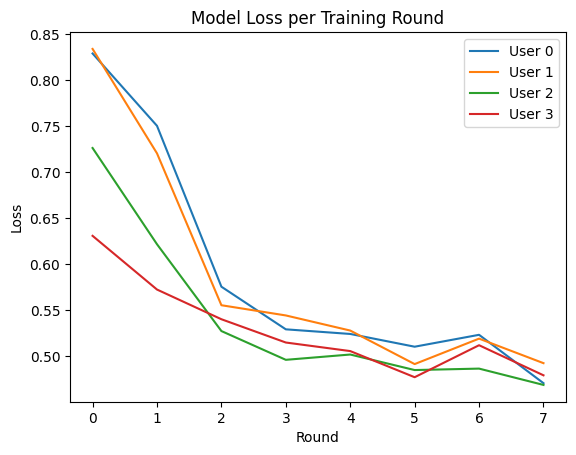

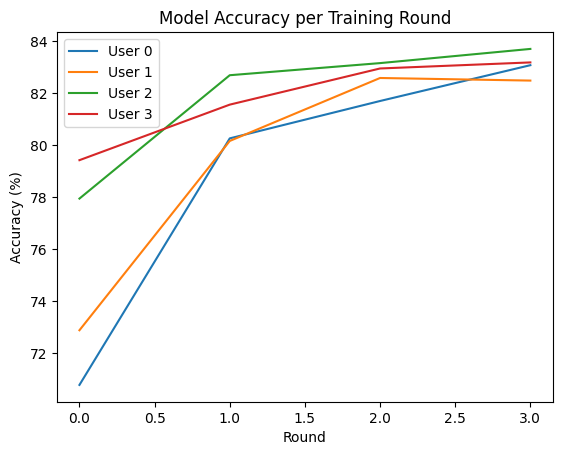

Deleted temporary model file: temp_model.h5


In [7]:
import os
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL
num_users = 4  # Set the number of users

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def plot_accuracy(user_accuracies):
    for user_id, accuracies in user_accuracies.items():
        plt.plot(accuracies, label=f'User {user_id}')
    plt.title('Model Accuracy per Training Round')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for the specified number of users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.linspace(0, len(X_train), num_users + 1, dtype=int)
user_data = [(X_train[start:end], y_train[start:end]) for start, end in zip(split_indices[:-1], split_indices[1:])]

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, user_data[0][0], user_data[0][1], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

num_rounds = 4  # Number of training rounds
user_losses = {user_id: [] for user_id in range(num_users)}  # To track losses for each user
user_accuracies = {user_id: [] for user_id in range(num_users)}  # To track accuracies for each user

# Download the latest global model once for each client
global_model = download_model(
    f"./workspace/sandbox_common/user0_cert.pem",
    f"./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for all users
local_models = [global_model] * num_users

for round_no in range(1, num_rounds + 1):
    for user_id in range(num_users):
        # Train the local model on the user's data
        loss, accuracy = train_model(local_models[user_id], user_data[user_id][0], user_data[user_id][1], X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_models[user_id])
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_models[0]  # Use any local model to update weights
    )

print("Federated Learning Process Completed.")

# Plot loss and accuracy graphs for each user
plot_loss(user_losses)
plot_accuracy(user_accuracies)

delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 8.6952 - accuracy: 0.6488 - val_loss: 1.4680 - val_accuracy: 0.6132
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 1.1617 - accuracy: 0.6715 - val_loss: 1.1967 - val_accuracy: 0.6497
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 4) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 3, Round 1...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 0.9565 - accuracy: 0.6990 - val_loss: 0.9274 - val_accuracy: 0.7012
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.7663 - accuracy: 0.7379 - val_loss: 0.8030 - val_accuracy: 0.7410
Up

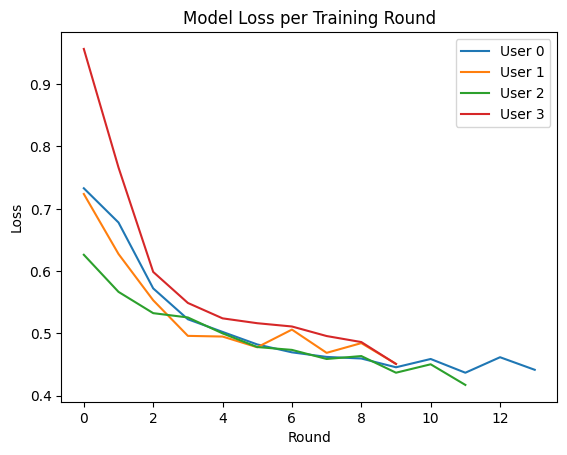

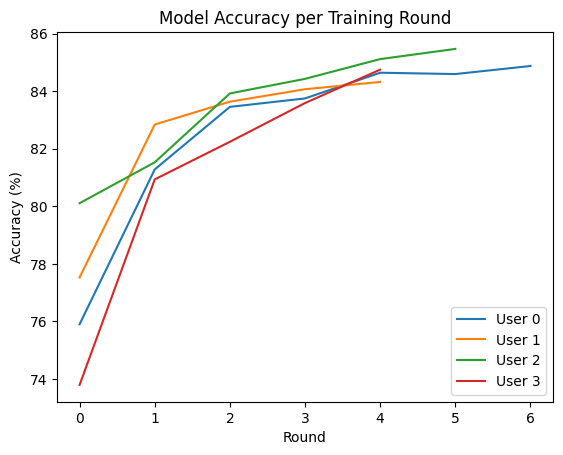

Deleted temporary model file: temp_model.h5


In [8]:
import os
import numpy as np
import requests
import json
import base64
import time
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL
num_users = 4  # Set the number of users
num_rounds = 8  # Increase the number of training rounds

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def plot_accuracy(user_accuracies):
    for user_id, accuracies in user_accuracies.items():
        plt.plot(accuracies, label=f'User {user_id}')
    plt.title('Model Accuracy per Training Round')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for the specified number of users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.linspace(0, len(X_train), num_users + 1, dtype=int)
user_data = [(X_train[start:end], y_train[start:end]) for start, end in zip(split_indices[:-1], split_indices[1:])]

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, user_data[0][0], user_data[0][1], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

user_losses = {user_id: [] for user_id in range(num_users)}  # To track losses for each user
user_accuracies = {user_id: [] for user_id in range(num_users)}  # To track accuracies for each user

# Download the latest global model once for each client
global_model = download_model(
    f"./workspace/sandbox_common/user0_cert.pem",
    f"./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for all users
local_models = [global_model] * num_users

for round_no in range(1, num_rounds + 1):
    # Randomly choose the number of clients for this round
    num_clients_this_round = random.randint(1, num_users)
    participating_clients = random.sample(range(num_users), num_clients_this_round)

    for user_id in participating_clients:
        # Train the local model on the user's data
        loss, accuracy = train_model(local_models[user_id], user_data[user_id][0], user_data[user_id][1], X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_models[user_id])
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_models[0]  # Use any local model to update weights
    )

print("Federated Learning Process Completed.")

# Plot loss and accuracy graphs for each user
plot_loss(user_losses)
plot_accuracy(user_accuracies)

delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 9.3469 - accuracy: 0.6585 - val_loss: 1.1690 - val_accuracy: 0.6489
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.9509 - accuracy: 0.6901 - val_loss: 0.9031 - val_accuracy: 0.6822
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 5) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 2, Round 1...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 0.8136 - accuracy: 0.7127 - val_loss: 0.7739 - val_accuracy: 0.7180
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.6906 - accuracy: 0.7317 - val_loss: 0.7156 - val_accuracy: 0.7177
Up

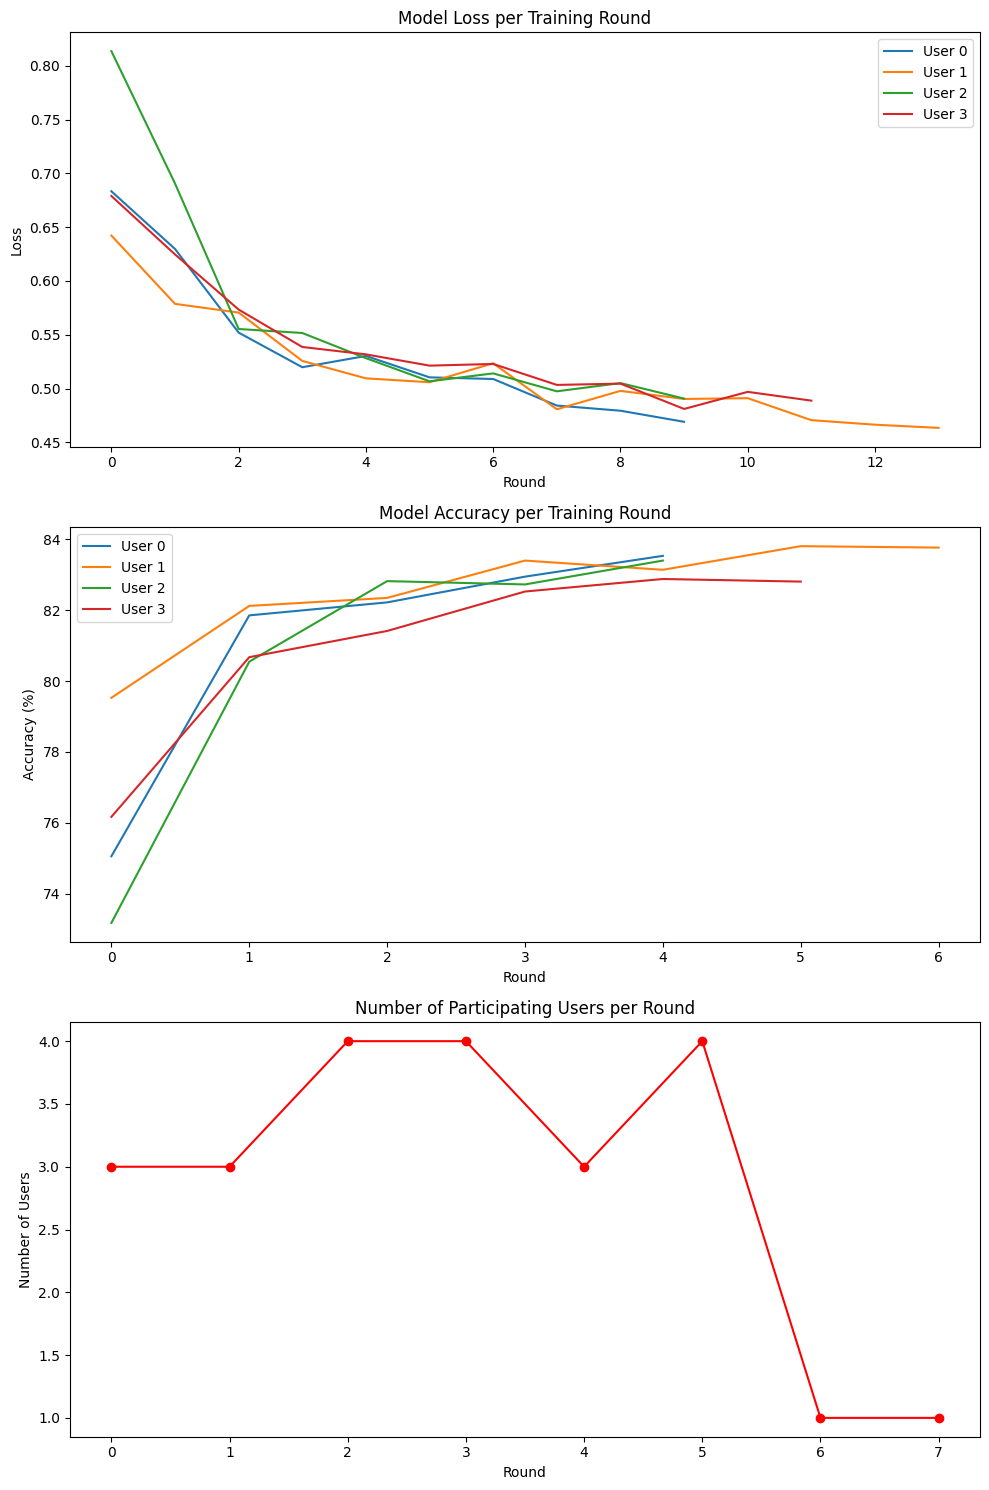

Deleted temporary model file: temp_model.h5


In [9]:
import os
import numpy as np
import requests
import json
import base64
import time
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL
num_users = 4  # Set the number of users
num_rounds = 8  # Increase the number of training rounds

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for user_id, losses in user_losses.items():
        ax1.plot(losses, label=f'User {user_id}')

    ax1.set_title('Model Loss per Training Round')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Round')
    ax1.legend()

    for user_id, accuracies in user_accuracies.items():
        ax2.plot(accuracies, label=f'User {user_id}')

    ax2.set_title('Model Accuracy per Training Round')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xlabel('Round')
    ax2.legend()

    ax3.plot(num_participating_users, marker='o', linestyle='-', color='r')
    ax3.set_title('Number of Participating Users per Round')
    ax3.set_ylabel('Number of Users')
    ax3.set_xlabel('Round')

    plt.tight_layout()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for the specified number of users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.linspace(0, len(X_train), num_users + 1, dtype=int)
user_data = [(X_train[start:end], y_train[start:end]) for start, end in zip(split_indices[:-1], split_indices[1:])]

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, user_data[0][0], user_data[0][1], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

user_losses = {user_id: [] for user_id in range(num_users)}  # To track losses for each user
user_accuracies = {user_id: [] for user_id in range(num_users)}  # To track accuracies for each user
num_participating_users = []  # To track the number of participating users in each round

# Download the latest global model once for each client
global_model = download_model(
    f"./workspace/sandbox_common/user0_cert.pem",
    f"./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for all users
local_models = [global_model] * num_users

for round_no in range(1, num_rounds + 1):
    # Randomly choose the number of clients for this round
    num_clients_this_round = random.randint(1, num_users)
    participating_clients = random.sample(range(num_users), num_clients_this_round)
    num_participating_users.append(num_clients_this_round)

    for user_id in participating_clients:
        # Train the local model on the user's data
        loss, accuracy = train_model(local_models[user_id], user_data[user_id][0], user_data[user_id][1], X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_models[user_id])
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_models[0]  # Use any local model to update weights
    )

print("Federated Learning Process Completed.")

# Plot loss, accuracy, and number of participating users graphs for each user
plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users)
delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
Deleted temporary model file: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 12.2507 - accuracy: 0.6795 - val_loss: 1.7020 - val_accuracy: 0.6451
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 1.2744 - accuracy: 0.7027 - val_loss: 1.1604 - val_accuracy: 0.6958
Latency for train_model: 4.3435187339782715 seconds
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 7) uploaded successfully.
Training model for User 0, Round 1...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 0.8419 - accuracy: 0.7215 - val_loss: 0.8702 - val_accuracy: 0.7084
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.7155 - accuracy: 0.7265 - val_loss: 0.9662 - val_accuracy: 0.6925
Latency for trai

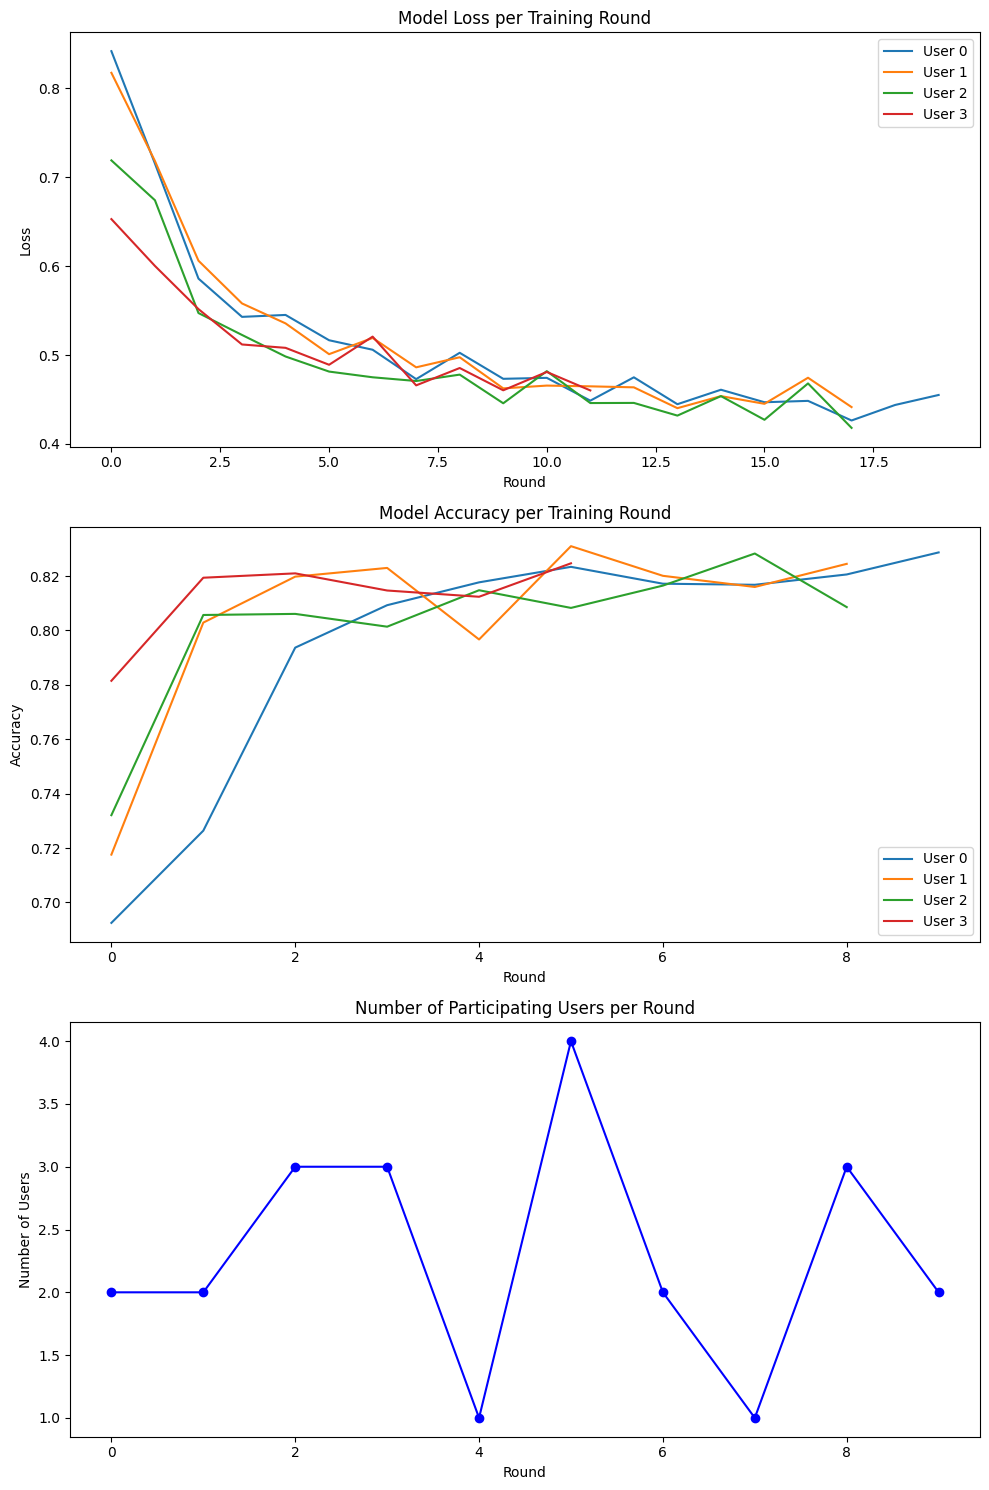

Deleted temporary model file: temp_model.h5


In [11]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        start_time = time.time()
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for download_global_model_weights: {latency} seconds")

        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    try:
        print("Aggregating weights for model:", model_id)
        start_time = time.time()
        response = requests.put(
            url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for aggregate_weights: {latency} seconds")

        if response.status_code == 200:
            print("Aggregation successful for model:", model_id)
        else:
            raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while aggregating weights: {e}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    try:
        print(f"Training model for User {user_id}, Round {round_no}...")
        start_time = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for train_model: {latency} seconds")

        return history.history['loss']
    except Exception as e:
        print(f"An error occurred while training the model: {e}")
        return []

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    try:
        print("Uploading initial global model...")
        payload = {
            "global_model": {
                "model_name": "FeedforwardModel",
                "model_data": model_base64
            }
        }
        response = requests.post(
            url=f"{server}/app/model/intial_model",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key),
            json=payload
        )

        if response.status_code == 200:
            model_data = response.json()
            model_id = model_data.get("model_id")
            model_name = model_data.get("model_name")
            print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
            return model_id
        else:
            print(f"Failed to upload initial model. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred while uploading initial model: {e}")
        return None

def flatten_weights(model_weights):
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    try:
        print(f"Uploading model weights for Round {round_no}...")
        start_time = time.time()
        payload = {
            "model_id": model_id,
            "weights_json": model_weights_base64,
            "round_no": round_no
        }
        response = requests.post(
            url=f"{server}/app/model/upload/local_model_weights",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key),
            json=payload
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for upload_model_weights: {latency} seconds")

        print(response.text)
        if response:
            print(f"Model weights uploaded successfully for Round {round_no}.")
        else:
            raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while uploading model weights: {e}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        try:
            print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
            start_time = time.time()
            response = requests.get(
                url=f"{server}/app/model/download/global?model_id={model_id}",
                verify="./workspace/sandbox_common/service_cert.pem",
                cert=(user_cert, user_key)
            )
            end_time = time.time()
            latency = end_time - start_time
            print(f"Latency for download_model: {latency} seconds")

            if response.status_code == 200:
                model_data = response.json().get("model_details", {})
                model_base64 = model_data

                if model_base64:
                    with open('temp_model.h5', 'wb') as file:
                        file.write(base64.b64decode(model_base64))
                    return load_model('temp_model.h5')
                else:
                    print("Model data not found in response, retrying...")
            else:
                print(f"Failed to download model. Status code: {response.status_code}, retrying...")

            time.sleep(2)
            attempts += 1
        except Exception as e:
            print(f"An error occurred during download_model: {e}")

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for user_id, losses in user_losses.items():
        ax1.plot(losses, label=f'User {user_id}')

    ax1.set_title('Model Loss per Training Round')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Round')
    ax1.legend()

    for user_id, accuracies in user_accuracies.items():
        ax2.plot(accuracies, label=f'User {user_id}')

    ax2.set_title('Model Accuracy per Training Round')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Round')
    ax2.legend()

    ax3.plot(num_participating_users, marker='o', linestyle='-', color='b')
    ax3.set_title('Number of Participating Users per Round')
    ax3.set_ylabel('Number of Users')
    ax3.set_xlabel('Round')

    plt.tight_layout()
    plt.show()
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and return accuracy."""
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Number of users
num_users = 4

# Split the dataset for multiple users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.array_split(np.arange(len(X_train)), num_users)
X_train_users = [X_train[indices] for indices in split_indices]
y_train_users = [y_train[indices] for indices in split_indices]

# Initialize and train the global model
global_model = create_model()
train_model(global_model, X_train_users[0], y_train_users[0], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)
initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

# Number of rounds and users
num_rounds = 10
num_participating_users = []

user_losses = {i: [] for i in range(num_users)}
user_accuracies = {i: [] for i in range(num_users)}

# Main federated learning loop
for round_no in range(1, num_rounds + 1):
    # Randomly choose the number of participating users for this round
    participating_users = random.randint(1, num_users)
    num_participating_users.append(participating_users)

    for user_id in range(num_users):
        # Randomly select users to simulate network dropouts
        if random.random() < 0.8:  # 80% chance of participating
            X_train_user = X_train_users[user_id]
            y_train_user = y_train_users[user_id]
            loss = train_model(global_model, X_train_user, y_train_user, X_test, y_test, user_id, round_no)
            accuracy = evaluate_model(global_model, X_test, y_test)
            user_losses[user_id].extend(loss)
            user_accuracies[user_id].append(accuracy)

            local_serialize_weights = serialize_weights(global_model)
            if local_serialize_weights:
                upload_model_weights(
                    local_serialize_weights,
                    f"./workspace/sandbox_common/user{user_id}_cert.pem",
                    f"./workspace/sandbox_common/user{user_id}_privk.pem",
                    round_no,
                    model_id=initial_model_id
                )

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=global_model
    )

# Plot loss and accuracy graphs for each user and number of participating users
plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users)
delete_temp_model_file()
